# Preservation potential maps

This notebook creates animations showing the cumulative erosion and preservation potential maps created in notebook `05`.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

### Select plate model

To use the plate model from the published paper (Alfonso et al., 2024), set `use_provided_plate_model` to `True`. Otherwise, leave `use_provided_plate_model` as `False` and set `plate_model_name` to a valid model name for the [`plate-model-manager`](https://github.com/michaelchin/plate-model-manager/blob/4f66423b53950bf42f5dac1228e61fd1e19fdf6e/models.json) package, or set `plate_model_name` to `None` and place GPlates files in a directory named `plate_model`.

| `use_provided_plate_model` | `plate_model_name` | result |
| - | - | - |
| `True` | Any | Use Alfonso et al., 2024 model |
| `False` | Model name string (e.g. `"muller2022"`) | Use specified plate model |
| `False` | `None` | Use files in `plate_model` directory |

In [2]:
use_provided_plate_model = True
plate_model_name = "muller2022"

### Set other parameters

In [3]:
# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = True

# Number of processes to use
n_jobs = 4

# Control verbosity level of logging output
verbose = False

These values will usually not need to be modified:

In [4]:
import os

from lib.check_files import check_prepared_data

if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = check_prepared_data("prepared_data")

outputs_dir = "outputs"
filename_template = r"image_{:0.0f}Ma.png"

erorate_dir = os.path.join("source_data", "ErosionDeposition")

If any of the following exist as environment variables, they will replace the values defined above:

In [5]:
n_jobs = int(os.environ.get("N_JOBS", n_jobs))
verbose = bool(int(os.environ.get("VERBOSE", verbose)))

## Notebook setup

Imports, definitions, etc.

### Imports

In [6]:
import re
import tempfile

import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
from gplately import PlotTopologies
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
)

from lib.animation import create_animation
from lib.check_files import (
    check_plate_model,
)
from lib.erodep import (
    plot_combined,
    plot_combined_maps,
    plot_erosion,
    plot_erosion_maps,
    plot_erosion_rate,
    plot_erosion_rate_maps,
    plot_likelihood,
    plot_likelihood_maps,
)
from lib.plate_models import (
    get_plate_reconstruction,
    get_plot_topologies,
)

NOTEBOOK = "get_ipython" in dir()

### Input and output files

In [7]:
# Input
input_filename = os.path.join(
    data_dir,
    "grid_data.csv",
)
deposits_filename = os.path.join(
    data_dir,
    "training_data_global.csv",
)
erosion_grids_dir = os.path.join(outputs_dir, "erosion_grids")
outputs_dir = os.path.join(outputs_dir, "global")

# Determine time steps
filenames = [
    i for i in os.listdir(erosion_grids_dir)
    if i.endswith(".nc")
]
pattern = re.compile(r"[0-9]+Ma")
times = sorted([
    int(pattern.findall(f)[0].replace("Ma", ""))
    for f in filenames
])

# Output
likelihood_dir = os.path.join(
    outputs_dir,
    "preservation_likelihood_grids",
)
prospectivity_dir = os.path.join(
    outputs_dir,
    "PU",
    "probability_grids",
)
output_filename_erosion = os.path.join(
    outputs_dir,
    "erosion.mp4",
)
output_filename_rate = os.path.join(
    outputs_dir,
    "erosion_rate.mp4",
)
output_filename_likelihood = os.path.join(
    outputs_dir,
    "likelihood.mp4",
)
output_filename_combined = os.path.join(
    outputs_dir,
    "PU",
    "prospectivity_likelihood.mp4",
)
output_filename_combined_nodeps = os.path.join(
    os.path.dirname(output_filename_combined),
    os.path.basename(output_filename_combined).replace(".mp4", "_nodeps.mp4"),
)

Plate model files:

In [8]:
plate_model_dir = "plate_model"
if use_provided_plate_model:
    check_plate_model(plate_model_dir, verbose=True)
    plate_model_name = None
plate_model, _tf = get_plate_reconstruction(
    model_name=plate_model_name,
    model_dir=plate_model_dir,
    filter_topologies=True,
)

if use_provided_plate_model:
    coastlines_filenames = [os.path.join(
        plate_model_dir,
        "StaticGeometries",
        "AgeGridInput",
        "CombinedTerranes.gpml",
    )]
    gplot = PlotTopologies(
        plate_model,
        coastlines=coastlines_filenames,
    )
else:
    gplot = get_plot_topologies(
        model_name=plate_model_name,
        model_dir=plate_model_dir,
        plate_reconstruction=plate_model,
        filter_topologies=True,
    )

projection = ccrs.Mollweide()

## Create animations

### Erosion rate

#### Example plot

Create an example plot at a single time step (by default, 135 Ma).

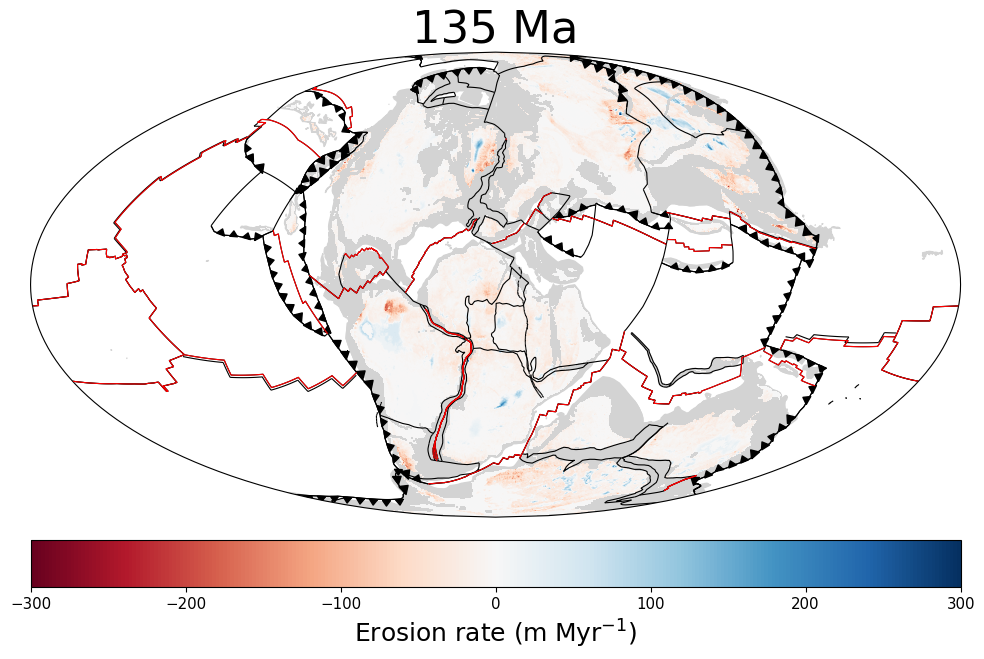

In [8]:
if NOTEBOOK:
    time = 135
    _ = plot_erosion_rate(
        time=time,
        gplot=gplot,
        input_dir=erorate_dir,
        projection=projection,
        output_filename=None,
    )

#### All plots

In [9]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_erosion_rate_maps(
        times=times,
        gplot=gplot,
        input_dir=erorate_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=verbose,
        output_template=filename_template,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_rate,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

### Cumulative erosion

#### Example plot

Create an example plot at a single time step (by default, 135 Ma).

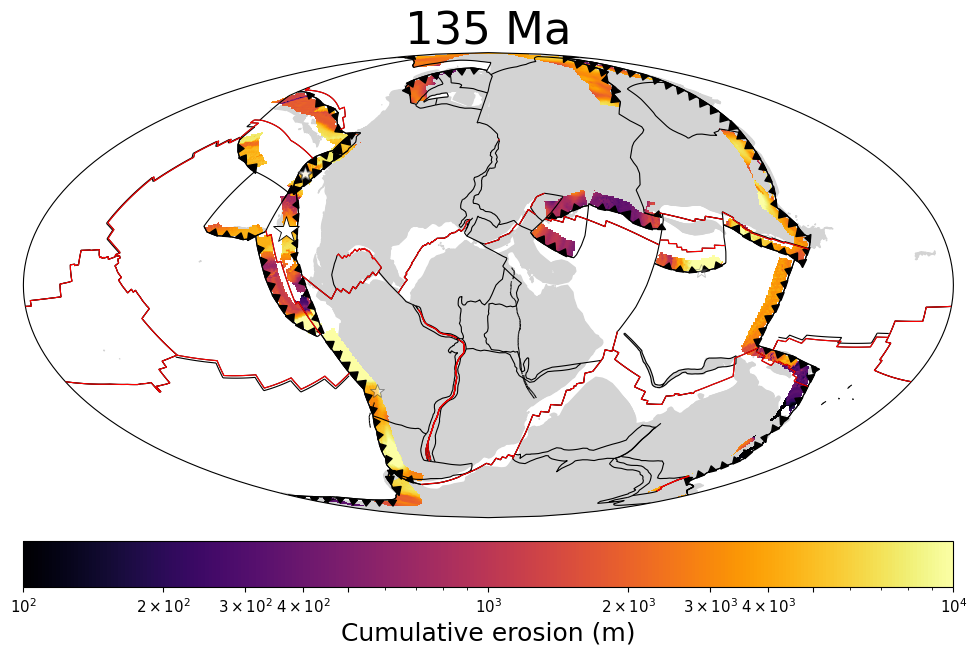

In [10]:
time = 135
_ = plot_erosion(
    time=time,
    gplot=gplot,
    input_dir=erosion_grids_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
)


#### All plots

In [11]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_erosion_maps(
        times=times,
        gplot=gplot,
        input_dir=erosion_grids_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=10 * int(verbose),
        output_template=filename_template,
        deposits=deposits_filename,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_erosion,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

### Preservation likelihood

#### Example plot

Create an example plot at a single time step (by default, 135 Ma).

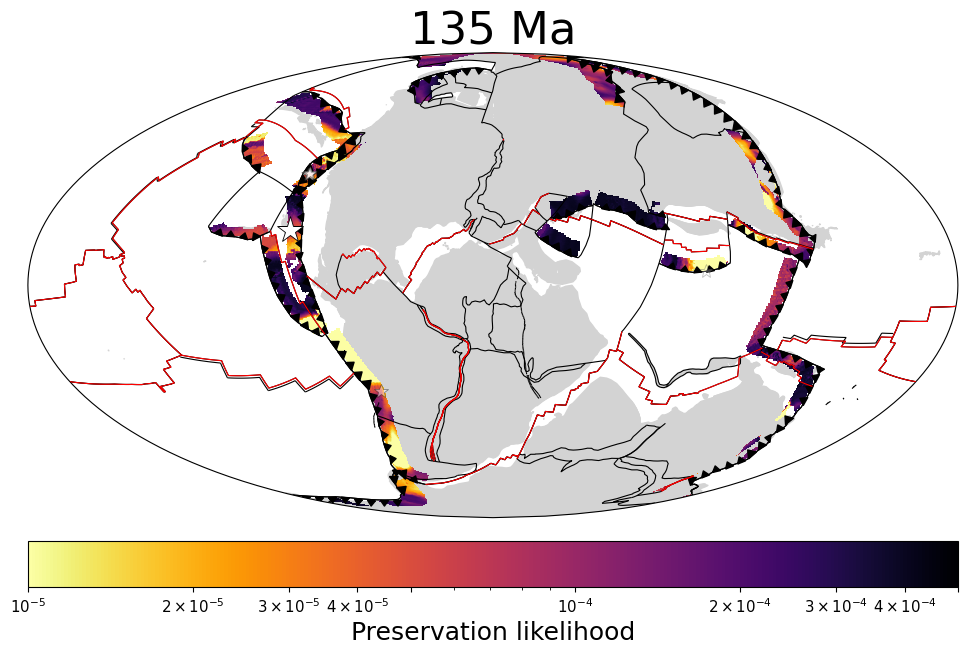

In [12]:
time = 135

_ = plot_likelihood(
    time=time,
    gplot=gplot,
    input_dir=likelihood_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
)


#### All plots

In [13]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_likelihood_maps(
        times=times,
        gplot=gplot,
        input_dir=likelihood_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=10 * int(verbose),
        output_template=filename_template,
        deposits=deposits_filename,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_likelihood,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

### Global model

#### Prospectivity $\times$ log(preservation likelihood)

In [11]:
# Transform and scale likelihood
x = np.dstack(
    [
        np.array(
            xr.load_dataset(
                os.path.join(
                    likelihood_dir,
                    f"preservation_likelihood_grid_{t:0.0f}Ma.nc",
                )
            )["z"]
        )
        for t in times
    ]
)
x = x[~np.logical_or(np.isnan(x), x == 0.0)].reshape((-1, 1))

transformer = make_pipeline(
    FunctionTransformer(np.log, np.exp, check_inverse=False),
    MinMaxScaler(),
).fit(x)


##### Example plot

Create an example plot at a single time step (by default, 135 Ma).

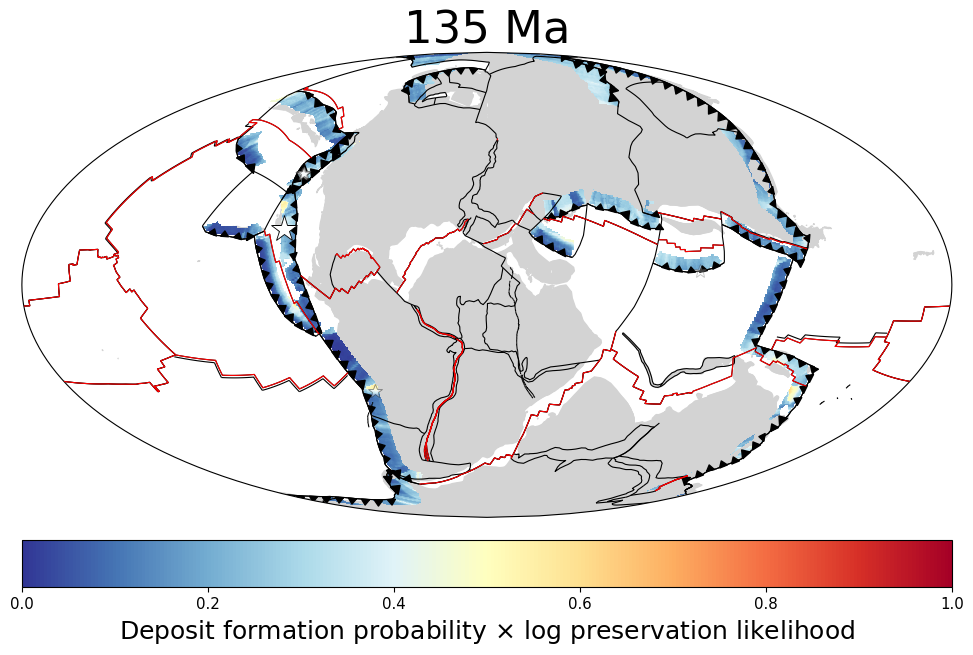

In [15]:
time = 135

_ = plot_combined(
    time=time,
    gplot=gplot,
    prospectivity_dir=prospectivity_dir,
    preservation_dir=likelihood_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
    method="likelihood",
    transformer=transformer,
)


##### All plots

In [16]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_combined_maps(
        times=times,
        gplot=gplot,
        prospectivity_dir=prospectivity_dir,
        preservation_dir=likelihood_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=10 * int(verbose),
        output_template=filename_template,
        deposits=deposits_filename,
        method="likelihood",
        transformer=transformer,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_combined,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

##### Plot without deposit locations

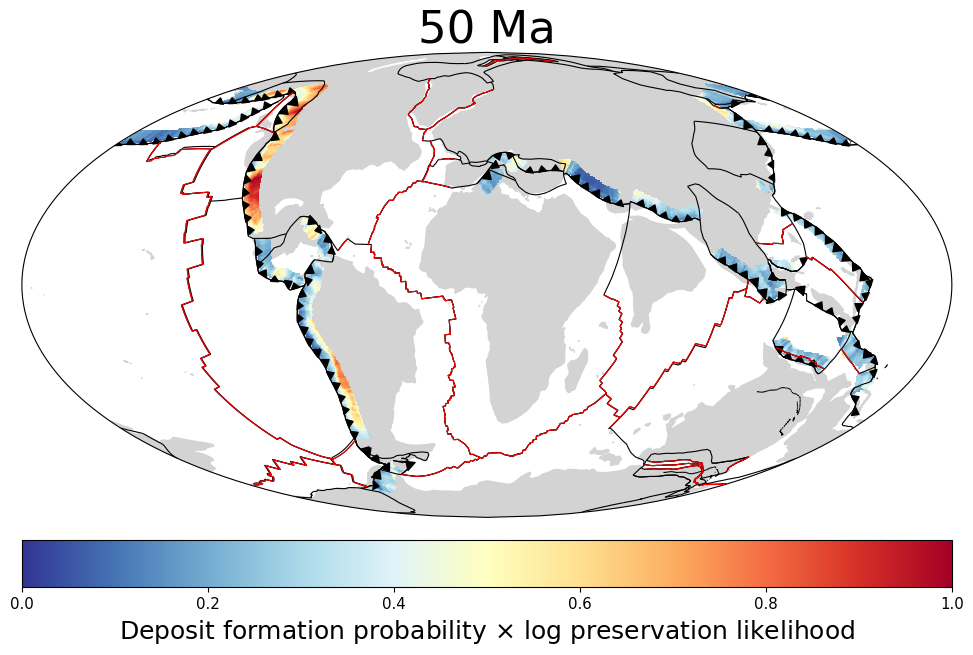

In [17]:
time = 50

_ = plot_combined(
    time=time,
    gplot=gplot,
    prospectivity_dir=prospectivity_dir,
    preservation_dir=likelihood_dir,
    projection=projection,
    output_filename=None,
    deposits=None,
    method="likelihood",
    transformer=transformer,
)


In [18]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_combined_maps(
        times=times,
        gplot=gplot,
        prospectivity_dir=prospectivity_dir,
        preservation_dir=likelihood_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=10 * int(verbose),
        output_template=filename_template,
        deposits=None,
        method="likelihood",
        transformer=transformer,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_combined_nodeps,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

### Regional models

In [13]:
algorithm = "PU"
probs_dirs_regions = [
    os.path.join(outputs_dir, algorithm, i)
    for i in os.listdir(os.path.join(outputs_dir, algorithm))
    if os.path.isdir(os.path.join(outputs_dir, algorithm, i))
    and i.startswith("probability_grids_")
]
with tempfile.TemporaryDirectory() as tmpdir:
    deposits = pd.read_csv(deposits_filename)
    for probs_dir_region in probs_dirs_regions:
        region = os.path.basename(probs_dir_region)
        r = "_".join(region.split("_")[2:])

        output_filename_region = output_filename_combined.replace(
            ".mp4",
            f"_{r}.mp4",
        )
        output_filename_region_nodeps = output_filename_region.replace(
            ".mp4",
            "_nodeps.mp4",
        )

        plot_combined_maps(
            times=times,
            gplot=gplot,
            prospectivity_dir=probs_dir_region,
            preservation_dir=likelihood_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=deposits[deposits["region"] == region],
            method="likelihood",
            transformer=transformer,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_region,
            fps=5,
            logger=None,
            threads=n_jobs,
        )

        plot_combined_maps(
            times=times,
            gplot=gplot,
            prospectivity_dir=probs_dir_region,
            preservation_dir=likelihood_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=None,
            method="likelihood",
            transformer=transformer,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_region_nodeps,
            fps=5,
            logger=None,
            threads=n_jobs,
        )